In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import emoji
from sentiment_analysis_spanish import sentiment_analysis
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, roc_curve, auc,roc_auc_score

### Lectura de datos

In [7]:
archivo = 'Chat de WhatsApp .txt'
patron = r'(\d{1,2}/\d{1,2}/\d{4}), (\d{1,2}:\d{2}\s?[ap]\.\s?m\.) - ([^:]+): (.+)'

In [8]:
Datos = []
with open(archivo, encoding = 'utf-8') as file:
    file.readline()
    Fecha, Hora, Autor = None, None, None
    while True: 
        linea = file.readline()
        if not linea:
            break
        linea = linea.strip()
        if re.match(patron, linea):
            splitLinea = linea.split(' - ')
            FechaHora = splitLinea[0]
            splitFechaHora = FechaHora.split(', ')
            Fecha = splitFechaHora[0]
            Hora = ' '.join(splitFechaHora[1:])
            Mensaje = ' '.join(splitLinea[1:])
            splitMensaje = Mensaje.split(': ')
            Autor = splitMensaje[0]
            Mensaje = ' '.join(splitMensaje[1:])
            Datos.append([Fecha, Hora, Autor, Mensaje])

df = pd.DataFrame(Datos, columns=['Fecha', 'Hora', 'Autor', 'Mensaje'])
    

### Analisis de Datos

In [9]:
df.shape

(262297, 4)

In [10]:
df

,Fecha,Hora,Autor,Mensaje
0,11/12/2018,11:50 p. m.,Teyssi,Prrossssss
1,11/12/2018,11:51 p. m.,Teyssi,Qué pedo vamos a ver la de Spiderman o se les ...
2,11/12/2018,11:52 p. m.,Carlos,Yo sí voy
3,11/12/2018,11:52 p. m.,Carlos,No sé qué pex con Paul
4,11/12/2018,11:52 p. m.,Teyssi,Ese Paul creo que ya sta jeton
...,...,...,...,...
262292,28/2/2025,1:52 p. m.,Carlos,Joder que crack
262293,28/2/2025,1:53 p. m.,Paul,https://x.com/majz99/status/189556177182361212...
262294,28/2/2025,1:53 p. m.,Paul,Lo sentiste así @5215551028094 ?
262295,28/2/2025,1:54 p. m.,Carlos,Jajajaja simon pero solo se movió una vez


In [11]:
df['Fecha'] = pd.to_datetime(df['Fecha'], format = "%d/%m/%Y")
df['Hora'] = pd.to_datetime(df['Hora'], format='mixed').dt.time # Debido a errores en el manejo de fecha de hora
                                                                # se usor el format 'mixed'

In [12]:
df

,Fecha,Hora,Autor,Mensaje
0,2018-12-11,23:50:00,Teyssi,Prrossssss
1,2018-12-11,23:51:00,Teyssi,Qué pedo vamos a ver la de Spiderman o se les ...
2,2018-12-11,23:52:00,Carlos,Yo sí voy
3,2018-12-11,23:52:00,Carlos,No sé qué pex con Paul
4,2018-12-11,23:52:00,Teyssi,Ese Paul creo que ya sta jeton
...,...,...,...,...
262292,2025-02-28,13:52:00,Carlos,Joder que crack
262293,2025-02-28,13:53:00,Paul,https://x.com/majz99/status/189556177182361212...
262294,2025-02-28,13:53:00,Paul,Lo sentiste así @5215551028094 ?
262295,2025-02-28,13:54:00,Carlos,Jajajaja simon pero solo se movió una vez


In [13]:
df.isnull().sum()

Fecha      0
Hora       0
Autor      0
Mensaje    0
dtype: int64

### Ingenieria de Variables

In [14]:
df['Tam_Mensaje'] = df['Mensaje'].str.len() # Caracteres por mensaje

In [15]:
df['Datetime'] = pd.to_datetime(df['Fecha'].astype(str) + ' ' + df['Hora'].astype(str))

In [16]:
df = df.sort_values(by = 'Datetime')

In [17]:
df['Tiempo_entre_msj'] = df['Datetime'].diff().dt.total_seconds() # Tiempo de respuesta del mensaje

In [18]:
df['Minutos_entre_msj'] = df['Tiempo_entre_msj']/60

In [19]:
df['Minutos_sig_msj'] = (df['Datetime'].shift(-1) - df['Datetime']).dt.total_seconds()/60

In [20]:
df

,Fecha,Hora,Autor,Mensaje,Tam_Mensaje,Datetime,Tiempo_entre_msj,Minutos_entre_msj,Minutos_sig_msj
0,2018-12-11,23:50:00,Teyssi,Prrossssss,10,2018-12-11 23:50:00,NaN,NaN,1.0
1,2018-12-11,23:51:00,Teyssi,Qué pedo vamos a ver la de Spiderman o se les ...,50,2018-12-11 23:51:00,60.0,1.0,1.0
2,2018-12-11,23:52:00,Carlos,Yo sí voy,9,2018-12-11 23:52:00,60.0,1.0,0.0
3,2018-12-11,23:52:00,Carlos,No sé qué pex con Paul,22,2018-12-11 23:52:00,0.0,0.0,0.0
4,2018-12-11,23:52:00,Teyssi,Ese Paul creo que ya sta jeton,30,2018-12-11 23:52:00,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
262292,2025-02-28,13:52:00,Carlos,Joder que crack,15,2025-02-28 13:52:00,0.0,0.0,1.0
262293,2025-02-28,13:53:00,Paul,https://x.com/majz99/status/189556177182361212...,77,2025-02-28 13:53:00,60.0,1.0,0.0
262294,2025-02-28,13:53:00,Paul,Lo sentiste así @5215551028094 ?,32,2025-02-28 13:53:00,0.0,0.0,1.0
262295,2025-02-28,13:54:00,Carlos,Jajajaja simon pero solo se movió una vez,41,2025-02-28 13:54:00,60.0,1.0,0.0


In [21]:
df['Num_palabras'] = df['Mensaje'].str.split().str.len() # Numero de palabras en el mensaje

In [22]:
df.describe()

,Fecha,Tam_Mensaje,Datetime,Tiempo_entre_msj,Minutos_entre_msj,Minutos_sig_msj,Num_palabras
count,262297,262297.000000,262297,2.622960e+05,262296.000000,262296.000000,262297.000000
mean,2023-03-07 10:44:40.500348928,19.077549,2023-03-08 02:59:32.899499520,7.479284e+02,12.465474,12.465474,3.701971
min,2018-12-11 00:00:00,1.000000,2018-12-11 23:50:00,0.000000e+00,0.000000,0.000000,1.000000
25%,2021-11-08 00:00:00,7.000000,2021-11-08 10:38:00,0.000000e+00,0.000000,0.000000,1.000000
50%,2023-07-04 00:00:00,15.000000,2023-07-04 12:15:00,0.000000e+00,0.000000,0.000000,2.000000
75%,2024-07-29 00:00:00,24.000000,2024-07-29 17:17:00,6.000000e+01,1.000000,1.000000,5.000000
max,2025-02-28 00:00:00,3574.000000,2025-02-28 13:54:00,1.823748e+07,303958.000000,303958.000000,195.000000
std,NaN,20.786935,NaN,3.921093e+04,653.515553,653.515553,3.436071


In [23]:
df[df['Minutos_entre_msj'] == df['Minutos_entre_msj'].min()]

,Fecha,Hora,Autor,Mensaje,Tam_Mensaje,Datetime,Tiempo_entre_msj,Minutos_entre_msj,Minutos_sig_msj,Num_palabras
3,2018-12-11,23:52:00,Carlos,No sé qué pex con Paul,22,2018-12-11 23:52:00,0.0,0.0,0.0,6
4,2018-12-11,23:52:00,Teyssi,Ese Paul creo que ya sta jeton,30,2018-12-11 23:52:00,0.0,0.0,1.0,7
6,2018-12-11,23:53:00,Teyssi,A ver si responde,17,2018-12-11 23:53:00,0.0,0.0,0.0,4
7,2018-12-11,23:53:00,Teyssi,El prro,7,2018-12-11 23:53:00,0.0,0.0,2.0,2
9,2018-12-11,23:55:00,Paul,Yo sí voy vatos,15,2018-12-11 23:55:00,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...
262287,2025-02-28,13:49:00,Carlos,Ay cabron,9,2025-02-28 13:49:00,0.0,0.0,1.0,2
262290,2025-02-28,13:52:00,Carlos,<Multimedia omitido>,20,2025-02-28 13:52:00,0.0,0.0,0.0,2
262292,2025-02-28,13:52:00,Carlos,Joder que crack,15,2025-02-28 13:52:00,0.0,0.0,1.0,3
262294,2025-02-28,13:53:00,Paul,Lo sentiste así @5215551028094 ?,32,2025-02-28 13:53:00,0.0,0.0,1.0,5


In [24]:
df['Tipo_msj'] = df['Mensaje'].apply(lambda x :
                                     "Multimedia" if  "<Multimedia omitido>" in str(x) 
                                     else "Enlace" if "http" in str(x) or "www" in str(x) 
                                     else "Texto") # Si el mensaje es texto, enlace o multimedia

In [25]:
df

,Fecha,Hora,Autor,Mensaje,Tam_Mensaje,Datetime,Tiempo_entre_msj,Minutos_entre_msj,Minutos_sig_msj,Num_palabras,Tipo_msj
0,2018-12-11,23:50:00,Teyssi,Prrossssss,10,2018-12-11 23:50:00,NaN,NaN,1.0,1,Texto
1,2018-12-11,23:51:00,Teyssi,Qué pedo vamos a ver la de Spiderman o se les ...,50,2018-12-11 23:51:00,60.0,1.0,1.0,12,Texto
2,2018-12-11,23:52:00,Carlos,Yo sí voy,9,2018-12-11 23:52:00,60.0,1.0,0.0,3,Texto
3,2018-12-11,23:52:00,Carlos,No sé qué pex con Paul,22,2018-12-11 23:52:00,0.0,0.0,0.0,6,Texto
4,2018-12-11,23:52:00,Teyssi,Ese Paul creo que ya sta jeton,30,2018-12-11 23:52:00,0.0,0.0,1.0,7,Texto
...,...,...,...,...,...,...,...,...,...,...,...
262292,2025-02-28,13:52:00,Carlos,Joder que crack,15,2025-02-28 13:52:00,0.0,0.0,1.0,3,Texto
262293,2025-02-28,13:53:00,Paul,https://x.com/majz99/status/189556177182361212...,77,2025-02-28 13:53:00,60.0,1.0,0.0,1,Enlace
262294,2025-02-28,13:53:00,Paul,Lo sentiste así @5215551028094 ?,32,2025-02-28 13:53:00,0.0,0.0,1.0,5,Texto
262295,2025-02-28,13:54:00,Carlos,Jajajaja simon pero solo se movió una vez,41,2025-02-28 13:54:00,60.0,1.0,0.0,8,Texto


In [26]:
df['Arroba'] = df['Mensaje'].apply(lambda x: '@' in str(x)) # Si el mensaje tiene arroba

In [27]:
df['Emojis'] = df['Mensaje'].apply(lambda x: any(char in emoji.EMOJI_DATA for char in str(x))) # Si el mensaje tiene emojis

In [28]:
df['Ratio_Mayus'] = df['Mensaje'].apply(lambda x: sum(1 for char in str(x) if char.isupper())/len(str(x))) # El ratio de mayusculas

In [29]:
df.sample(10)

,Fecha,Hora,Autor,Mensaje,Tam_Mensaje,Datetime,Tiempo_entre_msj,Minutos_entre_msj,Minutos_sig_msj,Num_palabras,Tipo_msj,Arroba,Emojis,Ratio_Mayus
93622,2022-04-22,08:38:00,Teyssi,ocupo explicaziones,19,2022-04-22 08:38:00,60.0,1.0,0.0,2,Texto,False,False,0.000000
134584,2023-07-22,17:25:00,Carlos,Ya me salió,11,2023-07-22 17:25:00,0.0,0.0,1.0,3,Texto,False,False,0.090909
213011,2024-09-18,18:45:00,Teyssi,un putero,9,2024-09-18 18:45:00,60.0,1.0,0.0,2,Texto,False,False,0.000000
181112,2024-06-07,19:50:00,Paul,Puedes donar a la comunidad indígena,36,2024-06-07 19:50:00,0.0,0.0,0.0,6,Texto,False,False,0.027778
117012,2023-01-25,11:32:00,Carlos,Jajajaja,8,2023-01-25 11:32:00,0.0,0.0,0.0,1,Texto,False,False,0.125000
133022,2023-07-16,21:48:00,Teyssi,<Multimedia omitido>,20,2023-07-16 21:48:00,60.0,1.0,8.0,2,Multimedia,False,False,0.050000
208073,2024-09-03,11:28:00,Teyssi,como ves que te puedo poner de patitas en la c...,68,2024-09-03 11:28:00,120.0,2.0,1.0,15,Texto,False,False,0.000000
86444,2022-02-13,18:39:00,Teyssi,Bien verga,10,2022-02-13 18:39:00,0.0,0.0,0.0,2,Texto,False,False,0.100000
115144,2023-01-13,00:08:00,Paul,Uy si supieras,14,2023-01-13 00:08:00,180.0,3.0,0.0,3,Texto,False,False,0.071429
124938,2023-04-20,16:42:00,Teyssi,KE PEDO PAPSES,14,2023-04-20 16:42:00,2940.0,49.0,0.0,3,Texto,False,False,0.857143


In [30]:
analy_esp = sentiment_analysis.SentimentAnalysisSpanish()
df['Sentimiento'] = df['Mensaje'].apply(lambda x: analy_esp.sentiment(str(x))) # Analizamos el sentimiento en el mensaje en espanol

/home/paul-h-roldan-hernandez/Diplo_env/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator CountVectorizer from version 0.23.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/paul-h-roldan-hernandez/Diplo_env/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MultinomialNB from version 0.23.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [31]:
df['Clasificacion_Sentimiento'] = df['Sentimiento'].apply(lambda x: 'Positivo' if x >= 0.5 else ('Negativo' if x <= -0.5 else 'Neutro'))
# Al analisis de sentimiento le asignamos una clasificaicion

In [32]:
df[df['Clasificacion_Sentimiento'] == 'Positivo']

,Fecha,Hora,Autor,Mensaje,Tam_Mensaje,Datetime,Tiempo_entre_msj,Minutos_entre_msj,Minutos_sig_msj,Num_palabras,Tipo_msj,Arroba,Emojis,Ratio_Mayus,Sentimiento,Clasificacion_Sentimiento
7,2018-12-11,23:53:00,Teyssi,El prro,7,2018-12-11 23:53:00,0.0,0.0,2.0,2,Texto,False,False,0.142857,0.513645,Positivo
25,2018-12-12,00:05:00,Teyssi,A poco es en San Nicolás,24,2018-12-12 00:05:00,240.0,4.0,1.0,6,Texto,False,False,0.125000,0.613302,Positivo
31,2018-12-14,13:44:00,Carlos,Está buena?,11,2018-12-14 13:44:00,0.0,0.0,18.0,2,Texto,False,False,0.090909,0.806015,Positivo
34,2018-12-14,14:02:00,Teyssi,El sabadaba prro de la prox semana,34,2018-12-14 14:02:00,0.0,0.0,21.0,7,Texto,False,False,0.029412,0.545113,Positivo
38,2018-12-14,14:26:00,Paul,Por mí está bien,16,2018-12-14 14:26:00,0.0,0.0,1.0,4,Texto,False,False,0.062500,0.506505,Positivo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262171,2025-02-26,21:52:00,Carlos,"Es coherente, la 450sr s está en 160 casi y la...",57,2025-02-26 21:52:00,60.0,1.0,0.0,14,Texto,False,False,0.017544,0.606647,Positivo
262214,2025-02-27,11:39:00,Teyssi,mejor,5,2025-02-27 11:39:00,60.0,1.0,0.0,1,Texto,False,False,0.000000,0.617922,Positivo
262210,2025-02-27,11:39:00,Teyssi,el pendejo,10,2025-02-27 11:39:00,0.0,0.0,0.0,2,Texto,False,False,0.000000,0.513645,Positivo
262249,2025-02-27,21:03:00,Paul,Es real?,8,2025-02-27 21:03:00,0.0,0.0,0.0,2,Texto,False,False,0.125000,0.817146,Positivo


In [33]:
df.describe()

,Fecha,Tam_Mensaje,Datetime,Tiempo_entre_msj,Minutos_entre_msj,Minutos_sig_msj,Num_palabras,Ratio_Mayus,Sentimiento
count,262297,262297.000000,262297,2.622960e+05,262296.000000,262296.000000,262297.000000,262297.000000,2.622970e+05
mean,2023-03-07 10:44:40.500348928,19.077549,2023-03-08 02:59:32.899499520,7.479284e+02,12.465474,12.465474,3.701971,0.098731,3.159514e-01
min,2018-12-11 00:00:00,1.000000,2018-12-11 23:50:00,0.000000e+00,0.000000,0.000000,1.000000,0.000000,3.264445e-55
25%,2021-11-08 00:00:00,7.000000,2021-11-08 10:38:00,0.000000e+00,0.000000,0.000000,1.000000,0.013158,1.095946e-01
50%,2023-07-04 00:00:00,15.000000,2023-07-04 12:15:00,0.000000e+00,0.000000,0.000000,2.000000,0.050000,3.551187e-01
75%,2024-07-29 00:00:00,24.000000,2024-07-29 17:17:00,6.000000e+01,1.000000,1.000000,5.000000,0.111111,4.978923e-01
max,2025-02-28 00:00:00,3574.000000,2025-02-28 13:54:00,1.823748e+07,303958.000000,303958.000000,195.000000,1.000000,9.999998e-01
std,NaN,20.786935,NaN,3.921093e+04,653.515553,653.515553,3.436071,0.163878,2.038185e-01


In [34]:
df['Ratio_Minus'] = df['Mensaje'].apply(lambda x: sum(1 for char in str(x) if char.islower())/len(str(x))) # Ratio de minusculas

In [35]:
df['Interr'] = df['Mensaje'].apply(lambda x: '?' in str(x)) # Si hay signo de interrogacion

In [36]:
df

,Fecha,Hora,Autor,Mensaje,Tam_Mensaje,Datetime,Tiempo_entre_msj,Minutos_entre_msj,Minutos_sig_msj,Num_palabras,Tipo_msj,Arroba,Emojis,Ratio_Mayus,Sentimiento,Clasificacion_Sentimiento,Ratio_Minus,Interr
0,2018-12-11,23:50:00,Teyssi,Prrossssss,10,2018-12-11 23:50:00,NaN,NaN,1.0,1,Texto,False,False,0.100000,0.497892,Neutro,0.900000,False
1,2018-12-11,23:51:00,Teyssi,Qué pedo vamos a ver la de Spiderman o se les ...,50,2018-12-11 23:51:00,60.0,1.0,1.0,12,Texto,False,False,0.040000,0.000171,Neutro,0.740000,False
2,2018-12-11,23:52:00,Carlos,Yo sí voy,9,2018-12-11 23:52:00,60.0,1.0,0.0,3,Texto,False,False,0.111111,0.132956,Neutro,0.666667,False
3,2018-12-11,23:52:00,Carlos,No sé qué pex con Paul,22,2018-12-11 23:52:00,0.0,0.0,0.0,6,Texto,False,False,0.090909,0.005576,Neutro,0.681818,False
4,2018-12-11,23:52:00,Teyssi,Ese Paul creo que ya sta jeton,30,2018-12-11 23:52:00,0.0,0.0,1.0,7,Texto,False,False,0.066667,0.001947,Neutro,0.733333,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262292,2025-02-28,13:52:00,Carlos,Joder que crack,15,2025-02-28 13:52:00,0.0,0.0,1.0,3,Texto,False,False,0.066667,0.302997,Neutro,0.800000,False
262293,2025-02-28,13:53:00,Paul,https://x.com/majz99/status/189556177182361212...,77,2025-02-28 13:53:00,60.0,1.0,0.0,1,Enlace,False,False,0.129870,0.497892,Neutro,0.389610,True
262294,2025-02-28,13:53:00,Paul,Lo sentiste así @5215551028094 ?,32,2025-02-28 13:53:00,0.0,0.0,1.0,5,Texto,True,False,0.031250,0.281321,Neutro,0.375000,True
262295,2025-02-28,13:54:00,Carlos,Jajajaja simon pero solo se movió una vez,41,2025-02-28 13:54:00,60.0,1.0,0.0,8,Texto,False,False,0.024390,0.034551,Neutro,0.804878,False


In [37]:
df["Num_dots"] = df['Mensaje'].str.split(".").str.len() - 1 # Numero de puntos en el mensaje

In [38]:
df

,Fecha,Hora,Autor,Mensaje,Tam_Mensaje,Datetime,Tiempo_entre_msj,Minutos_entre_msj,Minutos_sig_msj,Num_palabras,Tipo_msj,Arroba,Emojis,Ratio_Mayus,Sentimiento,Clasificacion_Sentimiento,Ratio_Minus,Interr,Num_dots
0,2018-12-11,23:50:00,Teyssi,Prrossssss,10,2018-12-11 23:50:00,NaN,NaN,1.0,1,Texto,False,False,0.100000,0.497892,Neutro,0.900000,False,0
1,2018-12-11,23:51:00,Teyssi,Qué pedo vamos a ver la de Spiderman o se les ...,50,2018-12-11 23:51:00,60.0,1.0,1.0,12,Texto,False,False,0.040000,0.000171,Neutro,0.740000,False,0
2,2018-12-11,23:52:00,Carlos,Yo sí voy,9,2018-12-11 23:52:00,60.0,1.0,0.0,3,Texto,False,False,0.111111,0.132956,Neutro,0.666667,False,0
3,2018-12-11,23:52:00,Carlos,No sé qué pex con Paul,22,2018-12-11 23:52:00,0.0,0.0,0.0,6,Texto,False,False,0.090909,0.005576,Neutro,0.681818,False,0
4,2018-12-11,23:52:00,Teyssi,Ese Paul creo que ya sta jeton,30,2018-12-11 23:52:00,0.0,0.0,1.0,7,Texto,False,False,0.066667,0.001947,Neutro,0.733333,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262292,2025-02-28,13:52:00,Carlos,Joder que crack,15,2025-02-28 13:52:00,0.0,0.0,1.0,3,Texto,False,False,0.066667,0.302997,Neutro,0.800000,False,0
262293,2025-02-28,13:53:00,Paul,https://x.com/majz99/status/189556177182361212...,77,2025-02-28 13:53:00,60.0,1.0,0.0,1,Enlace,False,False,0.129870,0.497892,Neutro,0.389610,True,1
262294,2025-02-28,13:53:00,Paul,Lo sentiste así @5215551028094 ?,32,2025-02-28 13:53:00,0.0,0.0,1.0,5,Texto,True,False,0.031250,0.281321,Neutro,0.375000,True,0
262295,2025-02-28,13:54:00,Carlos,Jajajaja simon pero solo se movió una vez,41,2025-02-28 13:54:00,60.0,1.0,0.0,8,Texto,False,False,0.024390,0.034551,Neutro,0.804878,False,0


In [39]:
df['Tipo_Conversacion'] = 'Esporadica'

In [40]:
df.loc[df['Minutos_entre_msj'] <= 10, 'Tipo_Conversacion'] = 'Continua'
df.loc[df['Minutos_entre_msj'].shift(-1) <= 10, 'Tipo_Conversacion'] = 'Continua' # Revisamos si en el mensaje siguiente se respondio en 
                                                                                  # menos de 10 minutos

In [41]:
df['Mes'] = df['Datetime'].dt.month # Mes del mensaje

In [42]:
df['Dia_semana'] = df['Datetime'].dt.day_name() # Dia de la semana del mensaje

In [43]:
df

,Fecha,Hora,Autor,Mensaje,Tam_Mensaje,Datetime,Tiempo_entre_msj,Minutos_entre_msj,Minutos_sig_msj,Num_palabras,...,Emojis,Ratio_Mayus,Sentimiento,Clasificacion_Sentimiento,Ratio_Minus,Interr,Num_dots,Tipo_Conversacion,Mes,Dia_semana
0,2018-12-11,23:50:00,Teyssi,Prrossssss,10,2018-12-11 23:50:00,NaN,NaN,1.0,1,...,False,0.100000,0.497892,Neutro,0.900000,False,0,Continua,12,Tuesday
1,2018-12-11,23:51:00,Teyssi,Qué pedo vamos a ver la de Spiderman o se les ...,50,2018-12-11 23:51:00,60.0,1.0,1.0,12,...,False,0.040000,0.000171,Neutro,0.740000,False,0,Continua,12,Tuesday
2,2018-12-11,23:52:00,Carlos,Yo sí voy,9,2018-12-11 23:52:00,60.0,1.0,0.0,3,...,False,0.111111,0.132956,Neutro,0.666667,False,0,Continua,12,Tuesday
3,2018-12-11,23:52:00,Carlos,No sé qué pex con Paul,22,2018-12-11 23:52:00,0.0,0.0,0.0,6,...,False,0.090909,0.005576,Neutro,0.681818,False,0,Continua,12,Tuesday
4,2018-12-11,23:52:00,Teyssi,Ese Paul creo que ya sta jeton,30,2018-12-11 23:52:00,0.0,0.0,1.0,7,...,False,0.066667,0.001947,Neutro,0.733333,False,0,Continua,12,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262292,2025-02-28,13:52:00,Carlos,Joder que crack,15,2025-02-28 13:52:00,0.0,0.0,1.0,3,...,False,0.066667,0.302997,Neutro,0.800000,False,0,Continua,2,Friday
262293,2025-02-28,13:53:00,Paul,https://x.com/majz99/status/189556177182361212...,77,2025-02-28 13:53:00,60.0,1.0,0.0,1,...,False,0.129870,0.497892,Neutro,0.389610,True,1,Continua,2,Friday
262294,2025-02-28,13:53:00,Paul,Lo sentiste así @5215551028094 ?,32,2025-02-28 13:53:00,0.0,0.0,1.0,5,...,False,0.031250,0.281321,Neutro,0.375000,True,0,Continua,2,Friday
262295,2025-02-28,13:54:00,Carlos,Jajajaja simon pero solo se movió una vez,41,2025-02-28 13:54:00,60.0,1.0,0.0,8,...,False,0.024390,0.034551,Neutro,0.804878,False,0,Continua,2,Friday


In [44]:
df['Hora_decimal'] = df['Hora'].apply(lambda x: x.hour + x.minute/60) # Asiganmos horarios por mensaje
df['Horario'] = pd.cut(df['Hora_decimal'], bins = [0,6,12,18,24], labels = ['Madrugada', 'Matutino','Vespertino','Noche'], right = False)

In [45]:
pd.set_option('display.max_columns', None)
df

,Fecha,Hora,Autor,Mensaje,Tam_Mensaje,Datetime,Tiempo_entre_msj,Minutos_entre_msj,Minutos_sig_msj,Num_palabras,Tipo_msj,Arroba,Emojis,Ratio_Mayus,Sentimiento,Clasificacion_Sentimiento,Ratio_Minus,Interr,Num_dots,Tipo_Conversacion,Mes,Dia_semana,Hora_decimal,Horario
0,2018-12-11,23:50:00,Teyssi,Prrossssss,10,2018-12-11 23:50:00,NaN,NaN,1.0,1,Texto,False,False,0.100000,0.497892,Neutro,0.900000,False,0,Continua,12,Tuesday,23.833333,Noche
1,2018-12-11,23:51:00,Teyssi,Qué pedo vamos a ver la de Spiderman o se les ...,50,2018-12-11 23:51:00,60.0,1.0,1.0,12,Texto,False,False,0.040000,0.000171,Neutro,0.740000,False,0,Continua,12,Tuesday,23.850000,Noche
2,2018-12-11,23:52:00,Carlos,Yo sí voy,9,2018-12-11 23:52:00,60.0,1.0,0.0,3,Texto,False,False,0.111111,0.132956,Neutro,0.666667,False,0,Continua,12,Tuesday,23.866667,Noche
3,2018-12-11,23:52:00,Carlos,No sé qué pex con Paul,22,2018-12-11 23:52:00,0.0,0.0,0.0,6,Texto,False,False,0.090909,0.005576,Neutro,0.681818,False,0,Continua,12,Tuesday,23.866667,Noche
4,2018-12-11,23:52:00,Teyssi,Ese Paul creo que ya sta jeton,30,2018-12-11 23:52:00,0.0,0.0,1.0,7,Texto,False,False,0.066667,0.001947,Neutro,0.733333,False,0,Continua,12,Tuesday,23.866667,Noche
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262292,2025-02-28,13:52:00,Carlos,Joder que crack,15,2025-02-28 13:52:00,0.0,0.0,1.0,3,Texto,False,False,0.066667,0.302997,Neutro,0.800000,False,0,Continua,2,Friday,13.866667,Vespertino
262293,2025-02-28,13:53:00,Paul,https://x.com/majz99/status/189556177182361212...,77,2025-02-28 13:53:00,60.0,1.0,0.0,1,Enlace,False,False,0.129870,0.497892,Neutro,0.389610,True,1,Continua,2,Friday,13.883333,Vespertino
262294,2025-02-28,13:53:00,Paul,Lo sentiste así @5215551028094 ?,32,2025-02-28 13:53:00,0.0,0.0,1.0,5,Texto,True,False,0.031250,0.281321,Neutro,0.375000,True,0,Continua,2,Friday,13.883333,Vespertino
262295,2025-02-28,13:54:00,Carlos,Jajajaja simon pero solo se movió una vez,41,2025-02-28 13:54:00,60.0,1.0,0.0,8,Texto,False,False,0.024390,0.034551,Neutro,0.804878,False,0,Continua,2,Friday,13.900000,Vespertino


In [46]:
df.isnull().sum()

Fecha                        0
Hora                         0
Autor                        0
Mensaje                      0
Tam_Mensaje                  0
Datetime                     0
Tiempo_entre_msj             1
Minutos_entre_msj            1
Minutos_sig_msj              1
Num_palabras                 0
Tipo_msj                     0
Arroba                       0
Emojis                       0
Ratio_Mayus                  0
Sentimiento                  0
Clasificacion_Sentimiento    0
Ratio_Minus                  0
Interr                       0
Num_dots                     0
Tipo_Conversacion            0
Mes                          0
Dia_semana                   0
Hora_decimal                 0
Horario                      0
dtype: int64

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 262297 entries, 0 to 262296
Data columns (total 24 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Fecha                      262297 non-null  datetime64[ns]
 1   Hora                       262297 non-null  object        
 2   Autor                      262297 non-null  object        
 3   Mensaje                    262297 non-null  object        
 4   Tam_Mensaje                262297 non-null  int64         
 5   Datetime                   262297 non-null  datetime64[ns]
 6   Tiempo_entre_msj           262296 non-null  float64       
 7   Minutos_entre_msj          262296 non-null  float64       
 8   Minutos_sig_msj            262296 non-null  float64       
 9   Num_palabras               262297 non-null  int64         
 10  Tipo_msj                   262297 non-null  object        
 11  Arroba                     262297 non-null  bool         

In [48]:
df['Relacion_Tam/N_palabras'] = df['Tam_Mensaje']/(df['Num_palabras'])

In [49]:
epsilon = 1e-6  # Un valor pequeño para evitar la división por cero
df['Palabras/tiempo'] = df['Num_palabras'] / df['Minutos_entre_msj'].replace(0, epsilon)

### Variables objetivo

Como variable objetivo continua vamos a usar Minutos_sig_msj
y como variable categorica  vamos a crear una nueva variable que sea Sig_msj_Conversacion_esporadica, en domnde venga si el siguiente mensaje es de una conversacion esporadica o continua

In [50]:
df_vc = df.dropna().copy()

In [51]:
df_vc

,Fecha,Hora,Autor,Mensaje,Tam_Mensaje,Datetime,Tiempo_entre_msj,Minutos_entre_msj,Minutos_sig_msj,Num_palabras,Tipo_msj,Arroba,Emojis,Ratio_Mayus,Sentimiento,Clasificacion_Sentimiento,Ratio_Minus,Interr,Num_dots,Tipo_Conversacion,Mes,Dia_semana,Hora_decimal,Horario,Relacion_Tam/N_palabras,Palabras/tiempo
1,2018-12-11,23:51:00,Teyssi,Qué pedo vamos a ver la de Spiderman o se les ...,50,2018-12-11 23:51:00,60.0,1.0,1.0,12,Texto,False,False,0.040000,0.000171,Neutro,0.740000,False,0,Continua,12,Tuesday,23.850000,Noche,4.166667,12.0
2,2018-12-11,23:52:00,Carlos,Yo sí voy,9,2018-12-11 23:52:00,60.0,1.0,0.0,3,Texto,False,False,0.111111,0.132956,Neutro,0.666667,False,0,Continua,12,Tuesday,23.866667,Noche,3.000000,3.0
3,2018-12-11,23:52:00,Carlos,No sé qué pex con Paul,22,2018-12-11 23:52:00,0.0,0.0,0.0,6,Texto,False,False,0.090909,0.005576,Neutro,0.681818,False,0,Continua,12,Tuesday,23.866667,Noche,3.666667,6000000.0
4,2018-12-11,23:52:00,Teyssi,Ese Paul creo que ya sta jeton,30,2018-12-11 23:52:00,0.0,0.0,1.0,7,Texto,False,False,0.066667,0.001947,Neutro,0.733333,False,0,Continua,12,Tuesday,23.866667,Noche,4.285714,7000000.0
5,2018-12-11,23:53:00,Carlos,Jaja pinshi bb,14,2018-12-11 23:53:00,60.0,1.0,0.0,3,Texto,False,False,0.071429,0.497892,Neutro,0.785714,False,0,Continua,12,Tuesday,23.883333,Noche,4.666667,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262290,2025-02-28,13:52:00,Carlos,<Multimedia omitido>,20,2025-02-28 13:52:00,0.0,0.0,0.0,2,Multimedia,False,False,0.050000,0.497892,Neutro,0.800000,False,0,Continua,2,Friday,13.866667,Vespertino,10.000000,2000000.0
262292,2025-02-28,13:52:00,Carlos,Joder que crack,15,2025-02-28 13:52:00,0.0,0.0,1.0,3,Texto,False,False,0.066667,0.302997,Neutro,0.800000,False,0,Continua,2,Friday,13.866667,Vespertino,5.000000,3000000.0
262293,2025-02-28,13:53:00,Paul,https://x.com/majz99/status/189556177182361212...,77,2025-02-28 13:53:00,60.0,1.0,0.0,1,Enlace,False,False,0.129870,0.497892,Neutro,0.389610,True,1,Continua,2,Friday,13.883333,Vespertino,77.000000,1.0
262294,2025-02-28,13:53:00,Paul,Lo sentiste así @5215551028094 ?,32,2025-02-28 13:53:00,0.0,0.0,1.0,5,Texto,True,False,0.031250,0.281321,Neutro,0.375000,True,0,Continua,2,Friday,13.883333,Vespertino,6.400000,5000000.0


### Outliers

In [52]:
variables_continuas = ['Tam_Mensaje','Minutos_entre_msj','Num_palabras','Ratio_Mayus','Sentimiento','Ratio_Minus','Num_dots','Relacion_Tam/N_palabras','Palabras/tiempo','Minutos_sig_msj']

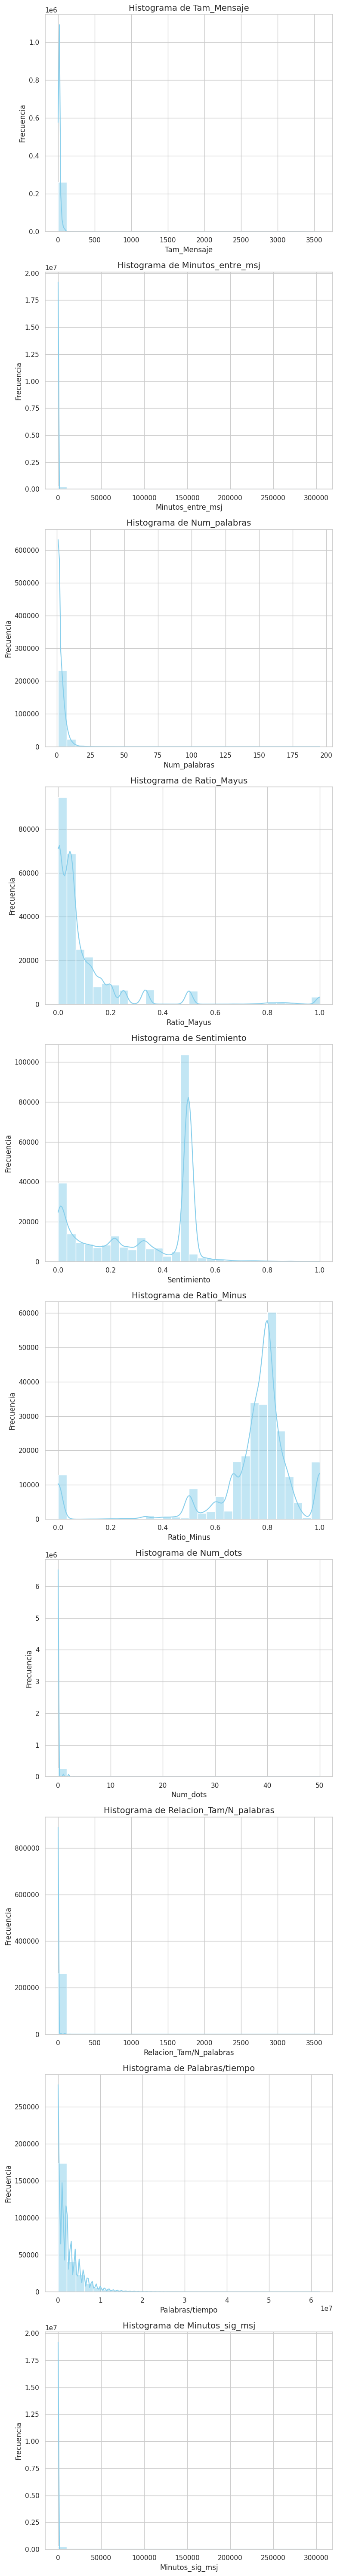

In [53]:
num_var = len(variables_continuas)
sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=len(variables_continuas), ncols=1, figsize=(8, 6 * len(variables_continuas)))

if len(variables_continuas) == 1:
    axes = [axes]

for i, col in enumerate(variables_continuas):
    sns.histplot(df_vc[col], kde=True, ax=axes[i], color='skyblue', bins=30)  
    axes[i].set_title(f'Histograma de {col}', fontsize=14)
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Frecuencia', fontsize=12)


plt.tight_layout()

plt.show()

In [54]:
df_vc.describe([0.01,.25,.5,.75,.99])

,Fecha,Tam_Mensaje,Datetime,Tiempo_entre_msj,Minutos_entre_msj,Minutos_sig_msj,Num_palabras,Ratio_Mayus,Sentimiento,Ratio_Minus,Num_dots,Mes,Hora_decimal,Relacion_Tam/N_palabras,Palabras/tiempo
count,262295,262295.000000,262295,2.622950e+05,262295.000000,262295.000000,262295.000000,262295.000000,2.622950e+05,262295.000000,262295.000000,262295.000000,262295.000000,262295.000000,2.622950e+05
mean,2023-03-07 10:49:11.891572224,19.077626,2023-03-08 03:04:04.218837248,7.479313e+02,12.465522,12.465518,3.701988,0.098731,3.159500e-01,0.735020,0.046638,6.944707,16.247869,6.060021,2.406940e+06
min,2018-12-11 00:00:00,1.000000,2018-12-11 23:51:00,0.000000e+00,0.000000,0.000000,1.000000,0.000000,3.264445e-55,0.000000,0.000000,1.000000,0.000000,1.000000,3.289928e-06
1%,2020-04-13 00:00:00,1.000000,2020-04-13 14:36:50.400000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,2.472903e-05,0.000000,0.000000,1.000000,0.250000,1.000000,9.433962e-03
25%,2021-11-08 00:00:00,7.000000,2021-11-08 10:40:00,0.000000e+00,0.000000,0.000000,1.000000,0.013158,1.095946e-01,0.714286,0.000000,4.000000,12.766667,3.800000,3.000000e+00
50%,2023-07-04 00:00:00,15.000000,2023-07-04 12:15:00,0.000000e+00,0.000000,0.000000,2.000000,0.050000,3.550950e-01,0.785714,0.000000,7.000000,16.616667,4.666667,1.000000e+06
75%,2024-07-29 00:00:00,24.000000,2024-07-29 17:05:30,6.000000e+01,1.000000,1.000000,5.000000,0.111111,4.978923e-01,0.821429,0.000000,10.000000,20.816667,6.000000,3.000000e+06
99%,2025-02-13 00:00:00,89.000000,2025-02-13 13:49:00,1.140000e+04,190.000000,190.000000,16.000000,1.000000,6.900541e-01,1.000000,2.000000,12.000000,23.783333,32.000000,1.400000e+07
max,2025-02-28 00:00:00,3574.000000,2025-02-28 13:54:00,1.823748e+07,303958.000000,303958.000000,195.000000,1.000000,9.999998e-01,1.000000,50.000000,12.000000,23.983333,3574.000000,6.200000e+07
std,NaN,20.786996,NaN,3.921101e+04,653.516798,653.516798,3.436079,0.163879,2.038187e-01,0.201854,0.315546,3.440418,5.296500,13.345082,3.084879e+06


In [55]:
for var in variables_continuas:
    #lower = df_vc[var].quantile(0.005)
    upper = df_vc[var].quantile(0.985)
    df_vc = df_vc[(df_vc[var] <= upper)]

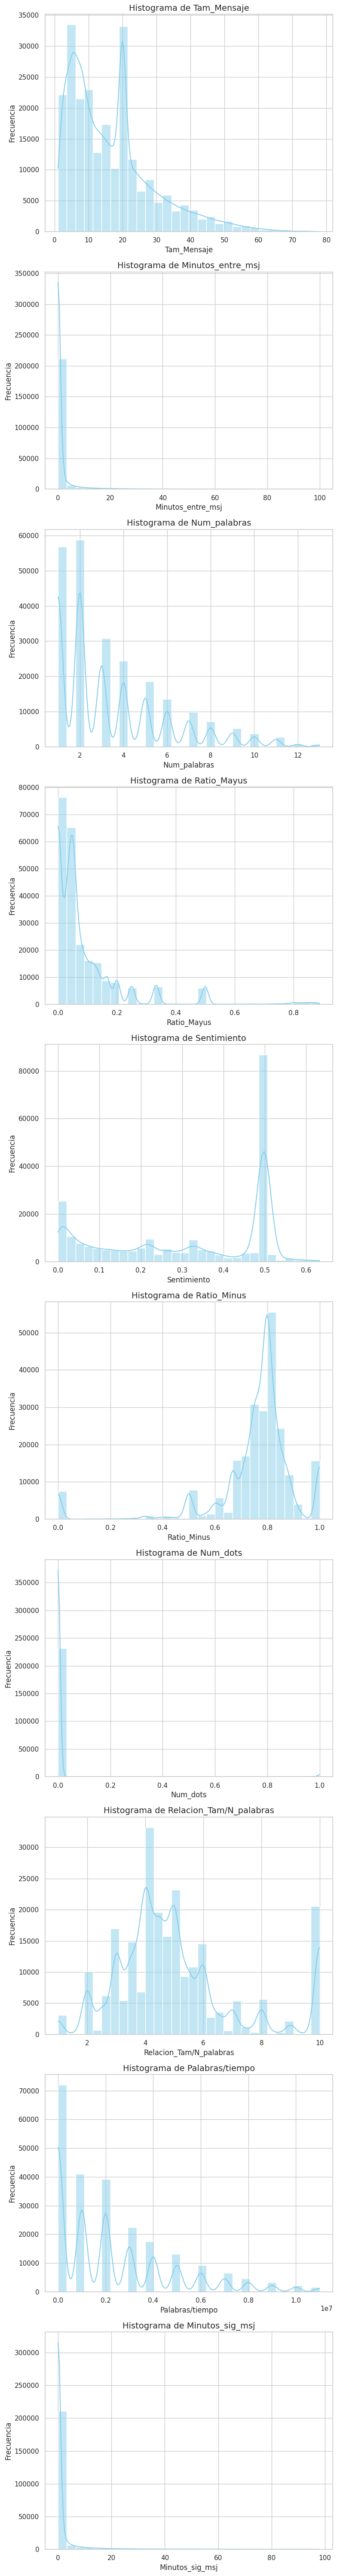

In [56]:
num_var = len(variables_continuas)
sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=len(variables_continuas), ncols=1, figsize=(8, 6 * len(variables_continuas)))

if len(variables_continuas) == 1:
    axes = [axes]

for i, col in enumerate(variables_continuas):
    sns.histplot(df_vc[col], kde=True, ax=axes[i], color='skyblue', bins=30)  
    axes[i].set_title(f'Histograma de {col}', fontsize=14)
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Frecuencia', fontsize=12)


plt.tight_layout()

plt.show()

In [57]:
df_vc["Palabras/tiempo_log"] = np.log1p(df_vc["Palabras/tiempo"]) 
df_vc['Num_dots_log'] = np.log1p(df_vc['Num_dots']) 
df_vc['Ratio_Mayus_log'] = np.log1p(df_vc['Ratio_Mayus']) 
df_vc['Num_palabras_log'] = np.log1p(df_vc['Num_palabras']) 
df_vc['Minutos_entre_msj_log'] = np.log1p(df_vc['Minutos_entre_msj']) 
df_vc['Tam_Mensaje_log'] = np.log1p(df_vc['Tam_Mensaje']) 
df_vc['Minutos_sig_msj_log'] = np.log1p(df_vc['Minutos_sig_msj']) 

In [58]:
variables_continuas = ['Tam_Mensaje','Minutos_entre_msj','Num_palabras','Ratio_Mayus','Sentimiento','Ratio_Minus',
'Num_dots','Relacion_Tam/N_palabras','Palabras/tiempo','Palabras/tiempo_log','Num_dots_log','Ratio_Mayus_log',
'Num_palabras_log','Minutos_entre_msj_log','Tam_Mensaje_log','Minutos_sig_msj','Minutos_sig_msj_log']

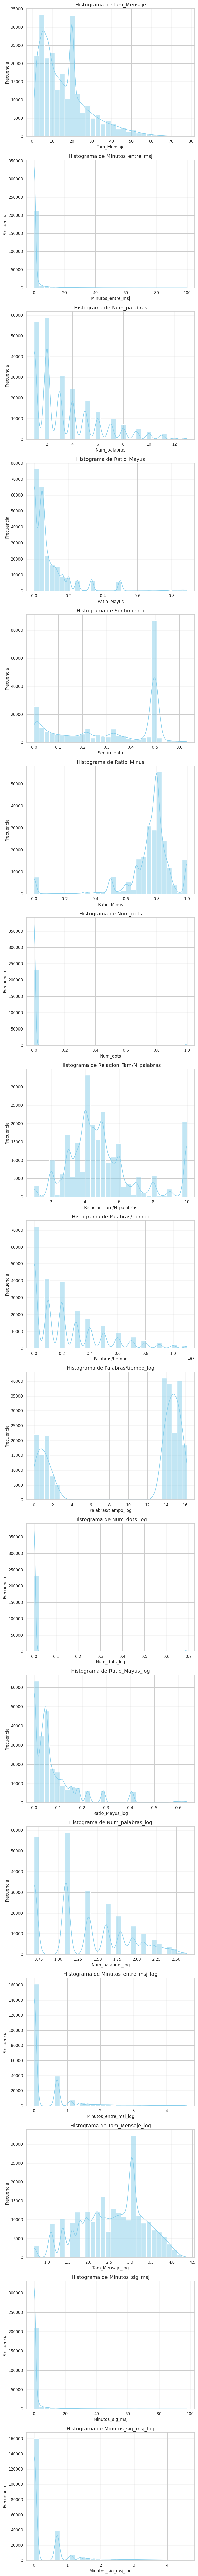

In [59]:
num_var = len(variables_continuas)
sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=len(variables_continuas), ncols=1, figsize=(8, 6 * len(variables_continuas)))

if len(variables_continuas) == 1:
    axes = [axes]

for i, col in enumerate(variables_continuas):
    sns.histplot(df_vc[col], kde=True, ax=axes[i], color='skyblue', bins=30)  
    axes[i].set_title(f'Histograma de {col}', fontsize=14)
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Frecuencia', fontsize=12)


plt.tight_layout()

plt.show()

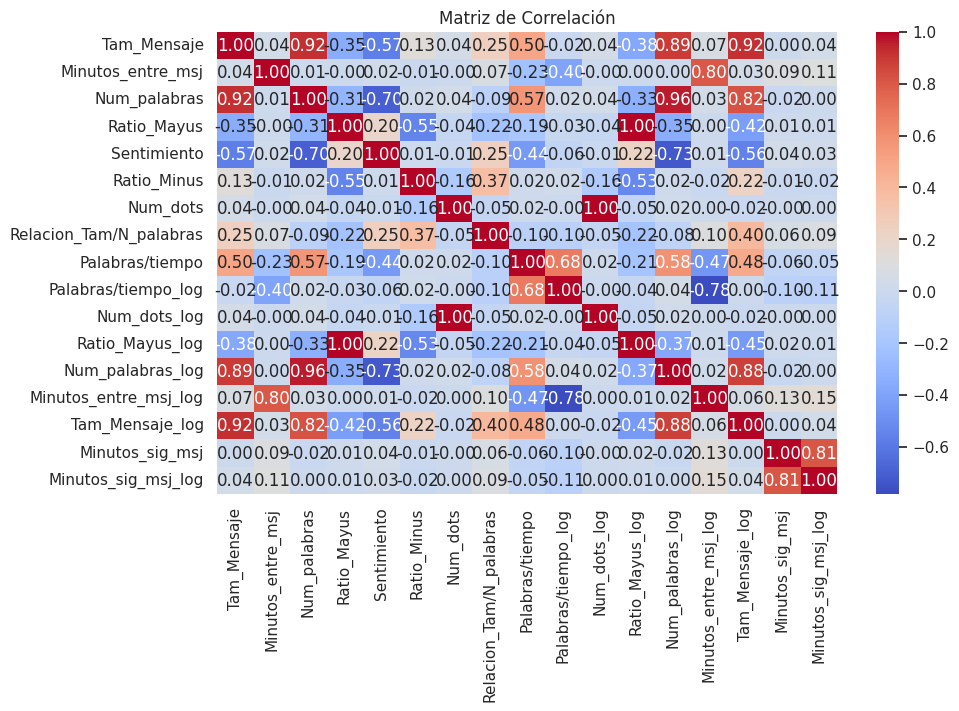

In [60]:
correlation_matrix = df_vc[variables_continuas].corr()
target_correlation = correlation_matrix["Minutos_sig_msj"].sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

Podemos ver que casi no hay relaciones lineales ni al aplicar transformaciones logaritmicas, por lo que no haremos un mdelo de regresion lineal o regresion logistica

In [61]:
df_vc.describe()

,Fecha,Tam_Mensaje,Datetime,Tiempo_entre_msj,Minutos_entre_msj,Minutos_sig_msj,Num_palabras,Ratio_Mayus,Sentimiento,Ratio_Minus,Num_dots,Mes,Hora_decimal,Relacion_Tam/N_palabras,Palabras/tiempo,Palabras/tiempo_log,Num_dots_log,Ratio_Mayus_log,Num_palabras_log,Minutos_entre_msj_log,Tam_Mensaje_log,Minutos_sig_msj_log
count,233325,233325.000000,233325,233325.000000,233325.000000,233325.000000,233325.000000,233325.000000,2.333250e+05,233325.000000,233325.000000,233325.000000,233325.000000,233325.000000,2.333250e+05,233325.000000,233325.000000,233325.000000,233325.000000,233325.000000,233325.000000,233325.000000
mean,2023-03-15 17:51:25.006750208,16.614315,2023-03-16 10:10:33.976727808,122.513147,2.041886,2.191497,3.423504,0.088675,3.091706e-01,0.750651,0.009622,6.972832,16.319158,4.995933,2.283262e+06,10.509848,0.006669,0.079244,1.344629,0.416862,2.608120,0.433325
min,2018-12-11 00:00:00,1.000000,2018-12-11 23:51:00,0.000000,0.000000,0.000000,1.000000,0.000000,1.132089e-12,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000e-02,0.009950,0.000000,0.000000,0.693147,0.000000,0.693147,0.000000
25%,2021-11-10 00:00:00,7.000000,2021-11-10 10:28:00,0.000000,0.000000,0.000000,2.000000,0.016129,1.139147e-01,0.727273,0.000000,4.000000,12.833333,3.750000,4.000000e+00,1.609438,0.000000,0.016000,1.098612,0.000000,2.079442,0.000000
50%,2023-07-18 00:00:00,14.000000,2023-07-18 11:46:00,0.000000,0.000000,0.000000,3.000000,0.050000,3.385253e-01,0.789474,0.000000,8.000000,16.683333,4.571429,2.000000e+06,14.508658,0.000000,0.048790,1.386294,0.000000,2.708050,0.000000
75%,2024-08-02 00:00:00,22.000000,2024-08-02 23:20:00,60.000000,1.000000,1.000000,5.000000,0.111111,4.978923e-01,0.826087,0.000000,10.000000,20.866667,5.750000,4.000000e+06,15.201805,0.000000,0.105361,1.791759,0.693147,3.135494,0.693147
max,2025-02-28 00:00:00,78.000000,2025-02-28 13:54:00,6000.000000,100.000000,98.000000,13.000000,0.888889,6.323721e-01,1.000000,1.000000,12.000000,23.983333,10.000000,1.100000e+07,16.213406,0.693147,0.635989,2.639057,4.615121,4.369448,4.595120
std,NaN,12.365570,NaN,493.509242,8.225154,8.569388,2.524049,0.128028,1.941221e-01,0.177589,0.097618,3.433161,5.243745,2.089051,2.486636e+06,6.403067,0.067664,0.102254,0.521916,0.821543,0.761201,0.845841


In [62]:
df_vc.drop('Num_dots',axis = 1,inplace = True)
df_vc.drop('Num_dots_log',axis = 1,inplace = True) # Despues de quitar los outliers estas variables quedaron vacias, por lo que las eliminamos

In [63]:
df_vc

,Fecha,Hora,Autor,Mensaje,Tam_Mensaje,Datetime,Tiempo_entre_msj,Minutos_entre_msj,Minutos_sig_msj,Num_palabras,Tipo_msj,Arroba,Emojis,Ratio_Mayus,Sentimiento,Clasificacion_Sentimiento,Ratio_Minus,Interr,Tipo_Conversacion,Mes,Dia_semana,Hora_decimal,Horario,Relacion_Tam/N_palabras,Palabras/tiempo,Palabras/tiempo_log,Ratio_Mayus_log,Num_palabras_log,Minutos_entre_msj_log,Tam_Mensaje_log,Minutos_sig_msj_log
1,2018-12-11,23:51:00,Teyssi,Qué pedo vamos a ver la de Spiderman o se les ...,50,2018-12-11 23:51:00,60.0,1.0,1.0,12,Texto,False,False,0.040000,0.000171,Neutro,0.740000,False,Continua,12,Tuesday,23.850000,Noche,4.166667,12.0,2.564949,0.039221,2.564949,0.693147,3.931826,0.693147
2,2018-12-11,23:52:00,Carlos,Yo sí voy,9,2018-12-11 23:52:00,60.0,1.0,0.0,3,Texto,False,False,0.111111,0.132956,Neutro,0.666667,False,Continua,12,Tuesday,23.866667,Noche,3.000000,3.0,1.386294,0.105361,1.386294,0.693147,2.302585,0.000000
3,2018-12-11,23:52:00,Carlos,No sé qué pex con Paul,22,2018-12-11 23:52:00,0.0,0.0,0.0,6,Texto,False,False,0.090909,0.005576,Neutro,0.681818,False,Continua,12,Tuesday,23.866667,Noche,3.666667,6000000.0,15.607270,0.087011,1.945910,0.000000,3.135494,0.000000
4,2018-12-11,23:52:00,Teyssi,Ese Paul creo que ya sta jeton,30,2018-12-11 23:52:00,0.0,0.0,1.0,7,Texto,False,False,0.066667,0.001947,Neutro,0.733333,False,Continua,12,Tuesday,23.866667,Noche,4.285714,7000000.0,15.761421,0.064539,2.079442,0.000000,3.433987,0.693147
5,2018-12-11,23:53:00,Carlos,Jaja pinshi bb,14,2018-12-11 23:53:00,60.0,1.0,0.0,3,Texto,False,False,0.071429,0.497892,Neutro,0.785714,False,Continua,12,Tuesday,23.883333,Noche,4.666667,3.0,1.386294,0.068993,1.386294,0.693147,2.708050,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262291,2025-02-28,13:52:00,Paul,Un narco D:,11,2025-02-28 13:52:00,60.0,1.0,0.0,3,Texto,False,False,0.181818,0.489863,Neutro,0.545455,False,Continua,2,Friday,13.866667,Vespertino,3.666667,3.0,1.386294,0.167054,1.386294,0.693147,2.484907,0.000000
262290,2025-02-28,13:52:00,Carlos,<Multimedia omitido>,20,2025-02-28 13:52:00,0.0,0.0,0.0,2,Multimedia,False,False,0.050000,0.497892,Neutro,0.800000,False,Continua,2,Friday,13.866667,Vespertino,10.000000,2000000.0,14.508658,0.048790,1.098612,0.000000,3.044522,0.000000
262292,2025-02-28,13:52:00,Carlos,Joder que crack,15,2025-02-28 13:52:00,0.0,0.0,1.0,3,Texto,False,False,0.066667,0.302997,Neutro,0.800000,False,Continua,2,Friday,13.866667,Vespertino,5.000000,3000000.0,14.914123,0.064539,1.386294,0.000000,2.772589,0.693147
262294,2025-02-28,13:53:00,Paul,Lo sentiste así @5215551028094 ?,32,2025-02-28 13:53:00,0.0,0.0,1.0,5,Texto,True,False,0.031250,0.281321,Neutro,0.375000,True,Continua,2,Friday,13.883333,Vespertino,6.400000,5000000.0,15.424949,0.030772,1.791759,0.000000,3.496508,0.693147


In [64]:
df_vc_enc = pd.get_dummies(df_vc, columns = ['Tipo_msj','Tipo_Conversacion','Autor']) # Para el modelo aplicamos dummies a variables que 
                                                                                      # lo requieren

In [65]:
df_vc_enc

,Fecha,Hora,Mensaje,Tam_Mensaje,Datetime,Tiempo_entre_msj,Minutos_entre_msj,Minutos_sig_msj,Num_palabras,Arroba,Emojis,Ratio_Mayus,Sentimiento,Clasificacion_Sentimiento,Ratio_Minus,Interr,Mes,Dia_semana,Hora_decimal,Horario,Relacion_Tam/N_palabras,Palabras/tiempo,Palabras/tiempo_log,Ratio_Mayus_log,Num_palabras_log,Minutos_entre_msj_log,Tam_Mensaje_log,Minutos_sig_msj_log,Tipo_msj_Enlace,Tipo_msj_Multimedia,Tipo_msj_Texto,Tipo_Conversacion_Continua,Tipo_Conversacion_Esporadica,Autor_Carlos,Autor_Meta AI,Autor_Paul,Autor_Teyssi
1,2018-12-11,23:51:00,Qué pedo vamos a ver la de Spiderman o se les ...,50,2018-12-11 23:51:00,60.0,1.0,1.0,12,False,False,0.040000,0.000171,Neutro,0.740000,False,12,Tuesday,23.850000,Noche,4.166667,12.0,2.564949,0.039221,2.564949,0.693147,3.931826,0.693147,False,False,True,True,False,False,False,False,True
2,2018-12-11,23:52:00,Yo sí voy,9,2018-12-11 23:52:00,60.0,1.0,0.0,3,False,False,0.111111,0.132956,Neutro,0.666667,False,12,Tuesday,23.866667,Noche,3.000000,3.0,1.386294,0.105361,1.386294,0.693147,2.302585,0.000000,False,False,True,True,False,True,False,False,False
3,2018-12-11,23:52:00,No sé qué pex con Paul,22,2018-12-11 23:52:00,0.0,0.0,0.0,6,False,False,0.090909,0.005576,Neutro,0.681818,False,12,Tuesday,23.866667,Noche,3.666667,6000000.0,15.607270,0.087011,1.945910,0.000000,3.135494,0.000000,False,False,True,True,False,True,False,False,False
4,2018-12-11,23:52:00,Ese Paul creo que ya sta jeton,30,2018-12-11 23:52:00,0.0,0.0,1.0,7,False,False,0.066667,0.001947,Neutro,0.733333,False,12,Tuesday,23.866667,Noche,4.285714,7000000.0,15.761421,0.064539,2.079442,0.000000,3.433987,0.693147,False,False,True,True,False,False,False,False,True
5,2018-12-11,23:53:00,Jaja pinshi bb,14,2018-12-11 23:53:00,60.0,1.0,0.0,3,False,False,0.071429,0.497892,Neutro,0.785714,False,12,Tuesday,23.883333,Noche,4.666667,3.0,1.386294,0.068993,1.386294,0.693147,2.708050,0.000000,False,False,True,True,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262291,2025-02-28,13:52:00,Un narco D:,11,2025-02-28 13:52:00,60.0,1.0,0.0,3,False,False,0.181818,0.489863,Neutro,0.545455,False,2,Friday,13.866667,Vespertino,3.666667,3.0,1.386294,0.167054,1.386294,0.693147,2.484907,0.000000,False,False,True,True,False,False,False,True,False
262290,2025-02-28,13:52:00,<Multimedia omitido>,20,2025-02-28 13:52:00,0.0,0.0,0.0,2,False,False,0.050000,0.497892,Neutro,0.800000,False,2,Friday,13.866667,Vespertino,10.000000,2000000.0,14.508658,0.048790,1.098612,0.000000,3.044522,0.000000,False,True,False,True,False,True,False,False,False
262292,2025-02-28,13:52:00,Joder que crack,15,2025-02-28 13:52:00,0.0,0.0,1.0,3,False,False,0.066667,0.302997,Neutro,0.800000,False,2,Friday,13.866667,Vespertino,5.000000,3000000.0,14.914123,0.064539,1.386294,0.000000,2.772589,0.693147,False,False,True,True,False,True,False,False,False
262294,2025-02-28,13:53:00,Lo sentiste así @5215551028094 ?,32,2025-02-28 13:53:00,0.0,0.0,1.0,5,True,False,0.031250,0.281321,Neutro,0.375000,True,2,Friday,13.883333,Vespertino,6.400000,5000000.0,15.424949,0.030772,1.791759,0.000000,3.496508,0.693147,False,False,True,True,False,False,False,True,False


In [66]:
encoder = LabelEncoder() # Para variables que requieren una codificacion pero con cierto sentido de continuidad uasamos LabelEncoder
df_vc_enc['Clasificacion_Sentimiento'] = encoder.fit_transform(df_vc_enc['Clasificacion_Sentimiento'])
df_vc_enc['Dia_semana'] = encoder.fit_transform(df_vc_enc['Dia_semana'])
df_vc_enc['Horario'] = encoder.fit_transform(df_vc_enc['Horario'])                                         

In [67]:
df_vc_enc

,Fecha,Hora,Mensaje,Tam_Mensaje,Datetime,Tiempo_entre_msj,Minutos_entre_msj,Minutos_sig_msj,Num_palabras,Arroba,Emojis,Ratio_Mayus,Sentimiento,Clasificacion_Sentimiento,Ratio_Minus,Interr,Mes,Dia_semana,Hora_decimal,Horario,Relacion_Tam/N_palabras,Palabras/tiempo,Palabras/tiempo_log,Ratio_Mayus_log,Num_palabras_log,Minutos_entre_msj_log,Tam_Mensaje_log,Minutos_sig_msj_log,Tipo_msj_Enlace,Tipo_msj_Multimedia,Tipo_msj_Texto,Tipo_Conversacion_Continua,Tipo_Conversacion_Esporadica,Autor_Carlos,Autor_Meta AI,Autor_Paul,Autor_Teyssi
1,2018-12-11,23:51:00,Qué pedo vamos a ver la de Spiderman o se les ...,50,2018-12-11 23:51:00,60.0,1.0,1.0,12,False,False,0.040000,0.000171,0,0.740000,False,12,5,23.850000,2,4.166667,12.0,2.564949,0.039221,2.564949,0.693147,3.931826,0.693147,False,False,True,True,False,False,False,False,True
2,2018-12-11,23:52:00,Yo sí voy,9,2018-12-11 23:52:00,60.0,1.0,0.0,3,False,False,0.111111,0.132956,0,0.666667,False,12,5,23.866667,2,3.000000,3.0,1.386294,0.105361,1.386294,0.693147,2.302585,0.000000,False,False,True,True,False,True,False,False,False
3,2018-12-11,23:52:00,No sé qué pex con Paul,22,2018-12-11 23:52:00,0.0,0.0,0.0,6,False,False,0.090909,0.005576,0,0.681818,False,12,5,23.866667,2,3.666667,6000000.0,15.607270,0.087011,1.945910,0.000000,3.135494,0.000000,False,False,True,True,False,True,False,False,False
4,2018-12-11,23:52:00,Ese Paul creo que ya sta jeton,30,2018-12-11 23:52:00,0.0,0.0,1.0,7,False,False,0.066667,0.001947,0,0.733333,False,12,5,23.866667,2,4.285714,7000000.0,15.761421,0.064539,2.079442,0.000000,3.433987,0.693147,False,False,True,True,False,False,False,False,True
5,2018-12-11,23:53:00,Jaja pinshi bb,14,2018-12-11 23:53:00,60.0,1.0,0.0,3,False,False,0.071429,0.497892,0,0.785714,False,12,5,23.883333,2,4.666667,3.0,1.386294,0.068993,1.386294,0.693147,2.708050,0.000000,False,False,True,True,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262291,2025-02-28,13:52:00,Un narco D:,11,2025-02-28 13:52:00,60.0,1.0,0.0,3,False,False,0.181818,0.489863,0,0.545455,False,2,0,13.866667,3,3.666667,3.0,1.386294,0.167054,1.386294,0.693147,2.484907,0.000000,False,False,True,True,False,False,False,True,False
262290,2025-02-28,13:52:00,<Multimedia omitido>,20,2025-02-28 13:52:00,0.0,0.0,0.0,2,False,False,0.050000,0.497892,0,0.800000,False,2,0,13.866667,3,10.000000,2000000.0,14.508658,0.048790,1.098612,0.000000,3.044522,0.000000,False,True,False,True,False,True,False,False,False
262292,2025-02-28,13:52:00,Joder que crack,15,2025-02-28 13:52:00,0.0,0.0,1.0,3,False,False,0.066667,0.302997,0,0.800000,False,2,0,13.866667,3,5.000000,3000000.0,14.914123,0.064539,1.386294,0.000000,2.772589,0.693147,False,False,True,True,False,True,False,False,False
262294,2025-02-28,13:53:00,Lo sentiste así @5215551028094 ?,32,2025-02-28 13:53:00,0.0,0.0,1.0,5,True,False,0.031250,0.281321,0,0.375000,True,2,0,13.883333,3,6.400000,5000000.0,15.424949,0.030772,1.791759,0.000000,3.496508,0.693147,False,False,True,True,False,False,False,True,False


In [68]:
variables_continuas = ['Tam_Mensaje','Minutos_entre_msj','Num_palabras','Ratio_Mayus','Sentimiento','Ratio_Minus',
'Relacion_Tam/N_palabras','Palabras/tiempo','Palabras/tiempo_log','Ratio_Mayus_log',
'Num_palabras_log','Minutos_entre_msj_log','Tam_Mensaje_log','Minutos_sig_msj','Minutos_sig_msj_log']
variables_categoricas = ['Arroba','Emojis','Tipo_msj_Multimedia','Tipo_msj_Texto','Tipo_Conversacion_Continua',
                         'Interr','Mes','Tipo_msj_Enlace',
                        'Tipo_Conversacion_Esporadica','Autor_Carlos','Autor_Paul','Autor_Teyssi'] # Separamos las variables por tipo

In [69]:
var_model = variables_continuas + variables_categoricas

In [70]:
df_model_vc = df_vc_enc[var_model] # Creamos el modelo sin las variables de fecha

In [71]:
sc = StandardScaler()
sc.fit(df_model_vc[variables_continuas]) # Aplicamos estandarizacion a variables continuas

StandardScaler()

In [72]:
df_model_vc.describe()

,Tam_Mensaje,Minutos_entre_msj,Num_palabras,Ratio_Mayus,Sentimiento,Ratio_Minus,Relacion_Tam/N_palabras,Palabras/tiempo,Palabras/tiempo_log,Ratio_Mayus_log,Num_palabras_log,Minutos_entre_msj_log,Tam_Mensaje_log,Minutos_sig_msj,Minutos_sig_msj_log,Mes
count,233325.000000,233325.000000,233325.000000,233325.000000,2.333250e+05,233325.000000,233325.000000,2.333250e+05,233325.000000,233325.000000,233325.000000,233325.000000,233325.000000,233325.000000,233325.000000,233325.000000
mean,16.614315,2.041886,3.423504,0.088675,3.091706e-01,0.750651,4.995933,2.283262e+06,10.509848,0.079244,1.344629,0.416862,2.608120,2.191497,0.433325,6.972832
std,12.365570,8.225154,2.524049,0.128028,1.941221e-01,0.177589,2.089051,2.486636e+06,6.403067,0.102254,0.521916,0.821543,0.761201,8.569388,0.845841,3.433161
min,1.000000,0.000000,1.000000,0.000000,1.132089e-12,0.000000,1.000000,1.000000e-02,0.009950,0.000000,0.693147,0.000000,0.693147,0.000000,0.000000,1.000000
25%,7.000000,0.000000,2.000000,0.016129,1.139147e-01,0.727273,3.750000,4.000000e+00,1.609438,0.016000,1.098612,0.000000,2.079442,0.000000,0.000000,4.000000
50%,14.000000,0.000000,3.000000,0.050000,3.385253e-01,0.789474,4.571429,2.000000e+06,14.508658,0.048790,1.386294,0.000000,2.708050,0.000000,0.000000,8.000000
75%,22.000000,1.000000,5.000000,0.111111,4.978923e-01,0.826087,5.750000,4.000000e+06,15.201805,0.105361,1.791759,0.693147,3.135494,1.000000,0.693147,10.000000
max,78.000000,100.000000,13.000000,0.888889,6.323721e-01,1.000000,10.000000,1.100000e+07,16.213406,0.635989,2.639057,4.615121,4.369448,98.000000,4.595120,12.000000


In [68]:
df_model_vc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 233325 entries, 1 to 262295
Data columns (total 27 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Tam_Mensaje                   233325 non-null  int64  
 1   Minutos_entre_msj             233325 non-null  float64
 2   Num_palabras                  233325 non-null  int64  
 3   Ratio_Mayus                   233325 non-null  float64
 4   Sentimiento                   233325 non-null  float64
 5   Ratio_Minus                   233325 non-null  float64
 6   Relacion_Tam/N_palabras       233325 non-null  float64
 7   Palabras/tiempo               233325 non-null  float64
 8   Palabras/tiempo_log           233325 non-null  float64
 9   Ratio_Mayus_log               233325 non-null  float64
 10  Num_palabras_log              233325 non-null  float64
 11  Minutos_entre_msj_log         233325 non-null  float64
 12  Tam_Mensaje_log               233325 non-null  fl

### Modelo Variable Continua

In [108]:
X = df_model_vc.drop(columns = ['Minutos_sig_msj'])
y = df_model_vc['Minutos_sig_msj']

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 42)

param_grid = { # Usamos RandomizedSearchCV para encontrar los mejores hyperparametros

    'n_estimators': np.arange(50,500,50),
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,4],  
}

rf = RandomForestRegressor(random_state=42) 

random_search = RandomizedSearchCV(
    estimator = rf,
    param_distributions = param_grid,
    n_iter = 50,
    cv =5,
    verbose = 2,
    random_state=42,
    n_jobs = -1
    
)


In [71]:
random_search.fit(X_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30, 40, 50],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450])},
                   random_state=42, verbose=2)

In [72]:
random_search.best_params_ # Mejores hyperparametros encontrados

{'n_estimators': np.int64(100),
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 40}

In [109]:
best_model = RandomForestRegressor(
    n_estimators = 100,
    min_samples_split = 2,
    min_samples_leaf = 1,
    max_depth = 40
    
)

In [113]:
best_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=40)

In [114]:
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_percentage_error') # Usamos crossvalidation para evaluar

In [115]:
print(cv_scores)

[-1.90350104e+14 -1.81261256e+14 -1.87974404e+14 -1.57287354e+14
 -2.08279241e+14]


In [118]:
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Error absoluto medio en el conjunto de prueba: {mae}")

Error absoluto medio en el conjunto de prueba: 0.0774651949346092


Al usar la métrica 'mean_absolute_error' con el set de prueba, calculamos el negativo del error absoluto medio (MAE), donde un valor más cercano a 0 indica un mejor rendimiento del modelo. En este caso, el resultado fue satisfactorio, con un valor de 0.077, lo que equivale a un 7.7% de error en la prediccion de tiempo.

### Modelo Variable Discreta

In [119]:
df_model_vd = df_vc_enc[var_model]

In [120]:
df_vc['Tipo_Conversacion'].value_counts()/len(df_vc) # Podemos ver uqe las clases esta muy desbalanceadas, por lo que haremos undersampling

Tipo_Conversacion
Continua      0.993203
Esporadica    0.006797
Name: count, dtype: float64

In [121]:
df_vc['Tipo_Conversacion'].value_counts()

Tipo_Conversacion
Continua      231739
Esporadica      1586
Name: count, dtype: int64

In [122]:
df_model_vd = df_model_vd.copy()
df_model_vd['Sig_msj_Conversacion_esporadica'] = df_model_vd['Tipo_Conversacion_Esporadica'].shift(-1)

In [123]:
df_model_vd.isnull().sum()

Tam_Mensaje                        0
Minutos_entre_msj                  0
Num_palabras                       0
Ratio_Mayus                        0
Sentimiento                        0
Ratio_Minus                        0
Relacion_Tam/N_palabras            0
Palabras/tiempo                    0
Palabras/tiempo_log                0
Ratio_Mayus_log                    0
Num_palabras_log                   0
Minutos_entre_msj_log              0
Tam_Mensaje_log                    0
Minutos_sig_msj                    0
Minutos_sig_msj_log                0
Arroba                             0
Emojis                             0
Tipo_msj_Multimedia                0
Tipo_msj_Texto                     0
Tipo_Conversacion_Continua         0
Interr                             0
Mes                                0
Tipo_msj_Enlace                    0
Tipo_Conversacion_Esporadica       0
Autor_Carlos                       0
Autor_Paul                         0
Autor_Teyssi                       0
S

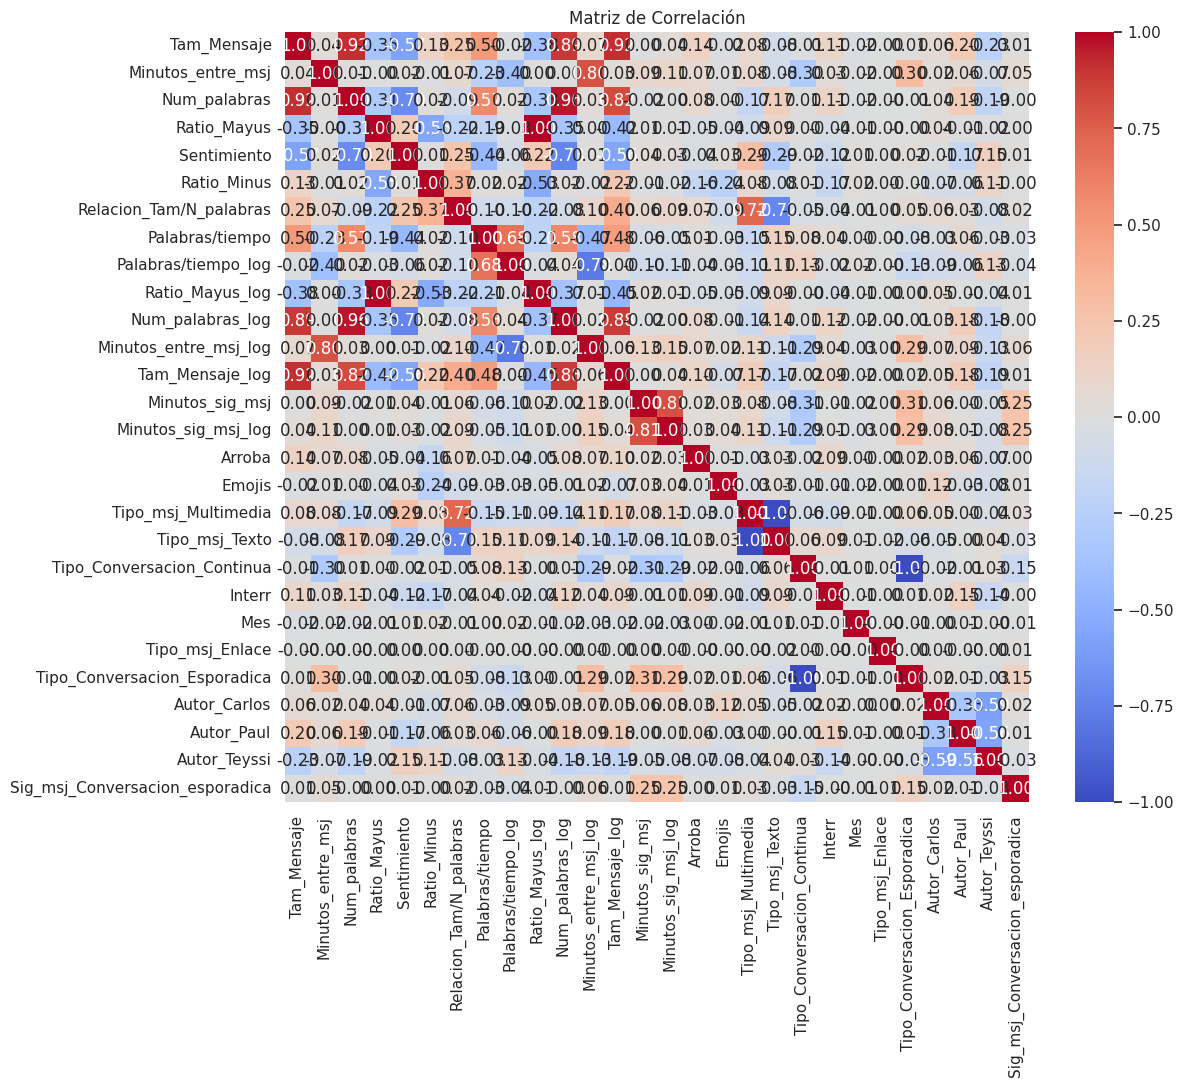

In [124]:
correlation_matrix = df_model_vd.corr()
target_correlation = correlation_matrix["Sig_msj_Conversacion_esporadica"].sort_values(ascending=False)
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

Podemos ver que nuevamenbte la relacion con la variable objetivo no es precisamente lineal

### UnderSampling

In [125]:
df_target_0 = df_model_vd[df_model_vd['Sig_msj_Conversacion_esporadica'] == 0]
df_target_1 = df_model_vd[df_model_vd['Sig_msj_Conversacion_esporadica'] == 1]
subsample = df_target_0.sample(frac = 0.06, random_state =42)
df_model_vd_sub = pd.concat([df_target_1, subsample])

In [126]:
df_model_vd_sub

,Tam_Mensaje,Minutos_entre_msj,Num_palabras,Ratio_Mayus,Sentimiento,Ratio_Minus,Relacion_Tam/N_palabras,Palabras/tiempo,Palabras/tiempo_log,Ratio_Mayus_log,Num_palabras_log,Minutos_entre_msj_log,Tam_Mensaje_log,Minutos_sig_msj,Minutos_sig_msj_log,Arroba,Emojis,Tipo_msj_Multimedia,Tipo_msj_Texto,Tipo_Conversacion_Continua,Interr,Mes,Tipo_msj_Enlace,Tipo_Conversacion_Esporadica,Autor_Carlos,Autor_Paul,Autor_Teyssi,Sig_msj_Conversacion_esporadica
71,30,0.0,7,0.033333,0.052035,0.733333,4.285714,7.000000e+06,15.761421,0.032790,2.079442,0.000000,3.433987,20.0,3.044522,False,False,False,True,True,True,12,False,False,False,True,False,True
76,52,1.0,11,0.019231,0.006929,0.788462,4.727273,1.100000e+01,2.484907,0.019048,2.484907,0.693147,3.970292,16.0,2.833213,False,False,False,True,True,False,12,False,False,False,False,True,True
77,19,16.0,4,0.052632,0.148500,0.736842,4.750000,2.500000e-01,0.223144,0.051293,1.609438,2.833213,2.995732,12.0,2.564949,False,False,False,True,False,True,12,False,True,False,True,False,True
78,9,12.0,2,0.111111,0.331823,0.666667,4.500000,1.666667e-01,0.154151,0.105361,1.098612,2.564949,2.302585,51.0,3.951244,False,True,False,True,False,False,12,False,True,True,False,False,True
217,20,0.0,2,0.050000,0.497892,0.800000,10.000000,2.000000e+06,14.508658,0.048790,1.098612,0.000000,3.044522,57.0,4.060443,False,False,True,False,True,False,12,False,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72606,6,0.0,2,0.166667,0.412556,0.666667,3.000000,2.000000e+06,14.508658,0.154151,1.098612,0.000000,1.945910,0.0,0.000000,False,False,False,True,True,False,11,False,False,False,False,True,False
20935,6,0.0,1,0.166667,0.497892,0.833333,6.000000,1.000000e+06,13.815512,0.154151,0.693147,0.000000,1.945910,0.0,0.000000,False,False,False,True,True,False,2,False,False,False,False,True,False
167209,9,0.0,3,0.111111,0.515944,0.666667,3.000000,3.000000e+06,14.914123,0.105361,1.386294,0.000000,2.302585,1.0,0.693147,False,False,False,True,True,False,4,False,False,False,False,True,False
256869,11,0.0,3,0.090909,0.085714,0.727273,3.666667,3.000000e+06,14.914123,0.087011,1.386294,0.000000,2.484907,0.0,0.000000,False,False,False,True,True,False,1,False,False,False,False,True,False


In [127]:
df_model_vd_sub['Sig_msj_Conversacion_esporadica'].value_counts()/len(df_model_vd_sub) # Hicimos un subsampling para que las clases
                                                                                       # quden aproximadamente de 90% y 10%

Sig_msj_Conversacion_esporadica
False    0.897611
True     0.102389
Name: count, dtype: float64

In [128]:
df_model_vd_sub.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15490 entries, 71 to 76936
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Tam_Mensaje                      15490 non-null  int64  
 1   Minutos_entre_msj                15490 non-null  float64
 2   Num_palabras                     15490 non-null  int64  
 3   Ratio_Mayus                      15490 non-null  float64
 4   Sentimiento                      15490 non-null  float64
 5   Ratio_Minus                      15490 non-null  float64
 6   Relacion_Tam/N_palabras          15490 non-null  float64
 7   Palabras/tiempo                  15490 non-null  float64
 8   Palabras/tiempo_log              15490 non-null  float64
 9   Ratio_Mayus_log                  15490 non-null  float64
 10  Num_palabras_log                 15490 non-null  float64
 11  Minutos_entre_msj_log            15490 non-null  float64
 12  Tam_Mensaje_log       

In [129]:
variables_continuas = ['Tam_Mensaje','Minutos_entre_msj','Num_palabras','Ratio_Mayus','Sentimiento','Ratio_Minus',
'Relacion_Tam/N_palabras','Palabras/tiempo','Palabras/tiempo_log','Ratio_Mayus_log',
'Num_palabras_log','Minutos_entre_msj_log','Tam_Mensaje_log','Minutos_sig_msj','Minutos_sig_msj_log']

In [130]:
sc = StandardScaler()
sc.fit(df_model_vd_sub[variables_continuas])

StandardScaler()

In [131]:
X = df_model_vd_sub.drop(columns = ['Sig_msj_Conversacion_esporadica'])
df_model_vd_sub['Sig_msj_Conversacion_esporadica'] = df_model_vd_sub['Sig_msj_Conversacion_esporadica'].astype(bool)
y = df_model_vd_sub['Sig_msj_Conversacion_esporadica']

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 42)

param_grid = { # Usamos RandomizedSearchCV para encontrar los mejores hyperparametros

    'n_estimators': np.arange(50,500,50),
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,4],  
}

rf = RandomForestClassifier(random_state=42) 

random_search = RandomizedSearchCV(
    estimator = rf,
    param_distributions = param_grid,
    n_iter = 50,
    cv =5,
    verbose = 2,
    random_state=42,
    n_jobs = -1
    
)

In [135]:
random_search.fit(X_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30, 40, 50],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450])},
                   random_state=42, verbose=2)

In [136]:
random_search.best_params_ # Mejores hyperparametros encontrados

{'n_estimators': np.int64(150),
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_depth': 10}

In [137]:
best_model = RandomForestClassifier(
    n_estimators = 150,
    min_samples_split = 2,
    min_samples_leaf = 4,
    max_depth = 10
    
)

In [138]:
best_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=4, n_estimators=150)

In [144]:
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='roc_auc') # Usamos crossvalidation para evaluar con roc

In [145]:
print(cv_scores)
print("ROC: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

[0.92908761 0.94203587 0.94571934 0.95269577 0.93583409]
ROC: 0.94 (+/- 0.02)
[CV] END max_depth=50, min_samples_leaf=1, min_samples_split=10, n_estimators=450; total time=   4.7s
[CV] END max_depth=50, min_samples_leaf=1, min_samples_split=10, n_estimators=350; total time=   3.7s
[CV] END max_depth=50, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   2.0s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=50, min_samples_leaf=4, min_samples_split=10, n_estimators=150; total time=   1.6s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   1.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV

In [149]:
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_pred_proba)

In [151]:
test_roc_auc # Comprobacion con el set de prueba

np.float64(0.939012780219948)

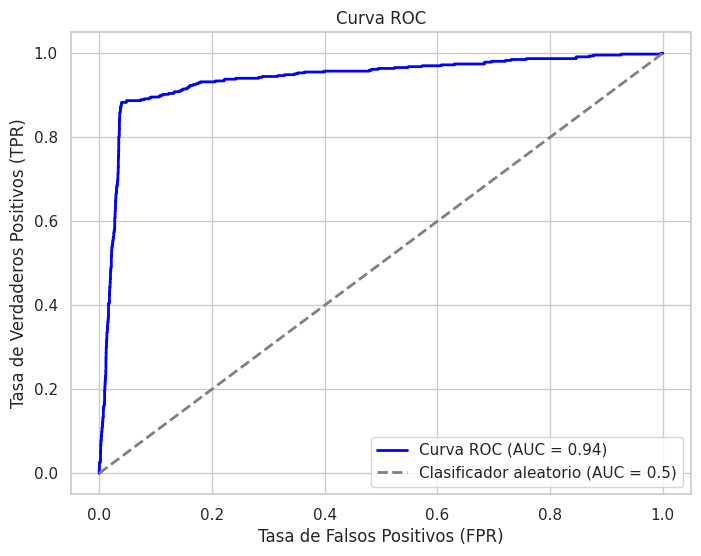

In [152]:
y_score = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Clasificador aleatorio (AUC = 0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()